In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Run this only if you don't already have these packages installed.
# You can comment out lines you don't want to run.
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm statsmodels shap


In [3]:
import os, zipfile, warnings, gc
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

import xgboost as xgb
import lightgbm as lgb
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (12,5)
sns.set(style="whitegrid")


In [4]:
data_path_zip = "/content/drive/MyDrive/Colab Notebooks/FDA/Dataset.zip"
df = None

if os.path.exists(data_path_zip):
    with zipfile.ZipFile(data_path_zip, 'r') as z:
        # list csv files
        csv_files = [f for f in z.namelist() if f.lower().endswith('.csv')]
        print("CSV files in zip:", csv_files)
        if len(csv_files) == 0:
            raise FileNotFoundError("No CSV files found in Dataset.zip")
        # choose the largest csv (likely main dataset)
        sizes = {f: z.getinfo(f).file_size for f in csv_files}
        main_csv = max(sizes, key=sizes.get)
        print("Loading:", main_csv)
        df = pd.read_csv(z.open(main_csv))
else:
    # fallback: try CSV in working dir
    csvs = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
    if len(csvs) == 0:
        raise FileNotFoundError("No Dataset.zip or csv file found in /mnt/data or current directory.")
    df = pd.read_csv(csvs[0])
    print("Loaded", csvs[0])

df.head()


CSV files in zip: ['Dataset/daily-minimum-temperatures-in-me.csv', 'Dataset/Electric_Production.csv', 'Dataset/monthly-beer-production-in-austr.csv', 'Dataset/sales-of-shampoo-over-a-three-ye.csv']
Loading: Dataset/daily-minimum-temperatures-in-me.csv


,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [5]:
# --- STEP 3: Handle datetime + target column explicitly ---

# 3.1 Rename datetime column
df.rename(columns={"Date": "datetime"}, inplace=True)
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df = df.sort_values("datetime").reset_index(drop=True)

# 3.2 Rename target column for easier use
df.rename(columns={"Daily minimum temperatures": "temp"}, inplace=True)

# 3.3 Ensure target is numeric
df["temp"] = pd.to_numeric(df["temp"], errors="coerce")

# 3.4 Drop rows with missing values in target
df = df.dropna(subset=["temp"]).reset_index(drop=True)

# 3.5 Define target_col
target_col = "temp"
print("Target column set to:", target_col)

# Quick check
print(df[["datetime", target_col]].head())


Target column set to: temp
    datetime  temp
0 1981-01-01  20.7
1 1981-01-02  17.9
2 1981-01-03  18.8
3 1981-01-04  14.6
4 1981-01-05  15.8


,count,mean,min,25%,50%,75%,max,std
datetime,3647,1986-01-01 03:18:12.733753792,1981-01-01 00:00:00,1983-07-03 12:00:00,1986-01-02 00:00:00,1988-07-01 12:00:00,1990-12-31 00:00:00,NaN
temp,3647.0,11.186647,0.0,8.3,11.0,14.0,26.3,4.061671


Missing fraction per column:
Series([], dtype: float64)


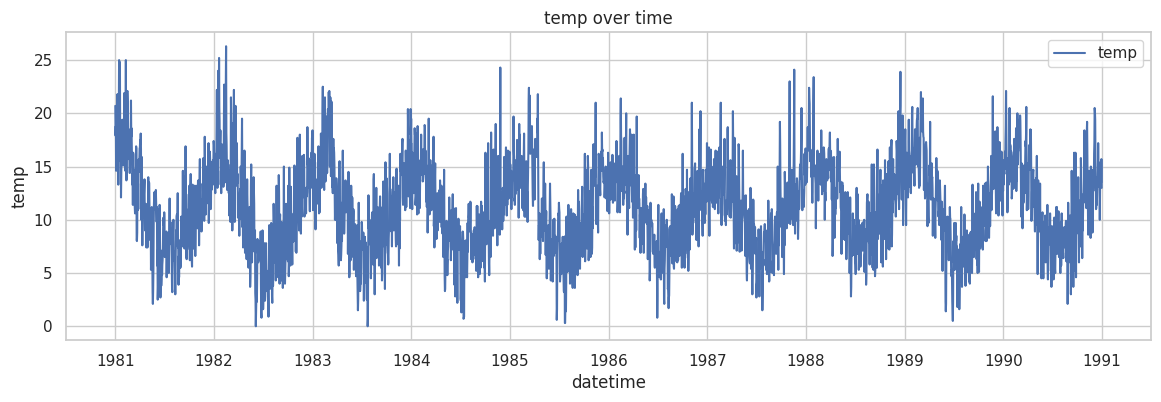

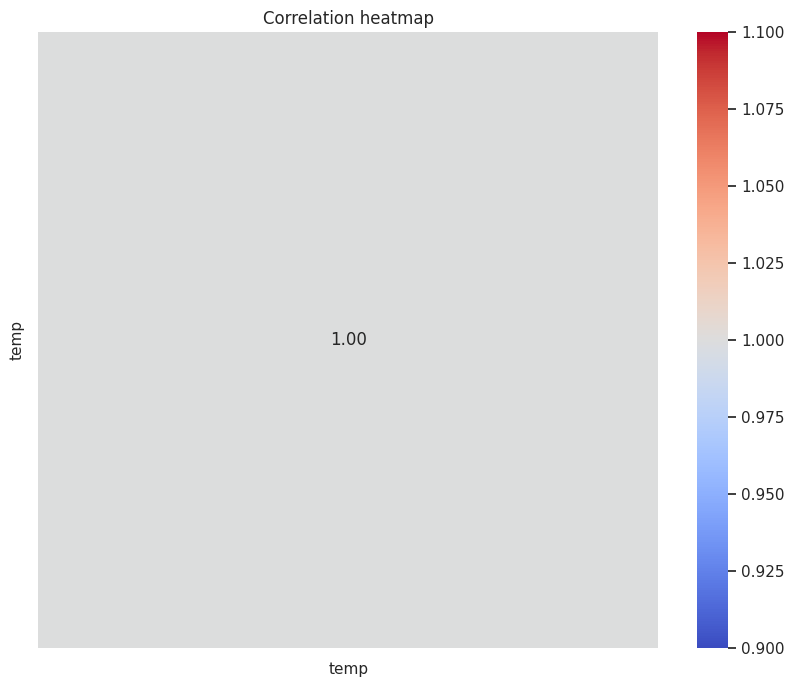

Inferred freq: D


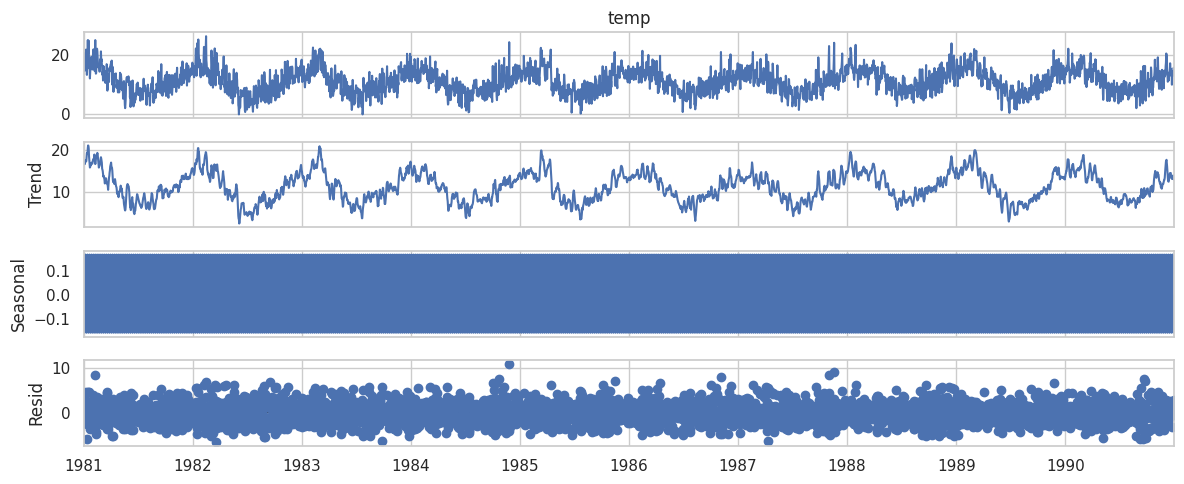

In [6]:
# Summary statistics
display(df.describe().T)

# Missing values
missing = df.isnull().mean().sort_values(ascending=False)
print("Missing fraction per column:")
print(missing[missing>0])

# Plot target over time
plt.figure(figsize=(14,4))
plt.plot(df['datetime'], df[target_col], label=target_col)
plt.title(f"{target_col} over time")
plt.xlabel("datetime")
plt.ylabel(target_col)
plt.legend()
plt.show()

# Correlation heatmap (numeric)
num_df = df.select_dtypes(include=[np.number]).copy()
corr = num_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation heatmap")
plt.show()

# Seasonal decomposition (if at least 2 full cycles)
# try to infer freq: daily, hourly etc.
try:
    df_indexed = df.set_index('datetime')
    inferred_freq = pd.infer_freq(df_indexed.index[:200])
    print("Inferred freq:", inferred_freq)
except Exception as e:
    inferred_freq = None
    print("Could not infer freq:", e)

# If daily or hourly we can decompose - choose period heuristically
period = None
if inferred_freq is not None:
    if 'H' in inferred_freq:
        period = 24
    elif 'D' in inferred_freq:
        period = 7  # weekly seasonality for daily data
    else:
        period = 7
else:
    period = 7

# Decompose
try:
    series = df.set_index('datetime')[target_col].asfreq(inferred_freq) if inferred_freq else df.set_index('datetime')[target_col]
    series = series.interpolate()  # fill small gaps
    decomposition = sm.tsa.seasonal_decompose(series, period=period, model='additive', extrapolate_trend='freq')
    decomposition.plot()
    plt.show()
except Exception as e:
    print("Seasonal decomposition failed:", e)


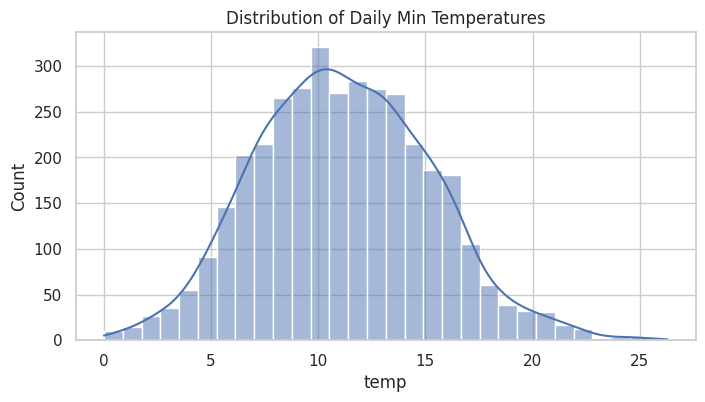

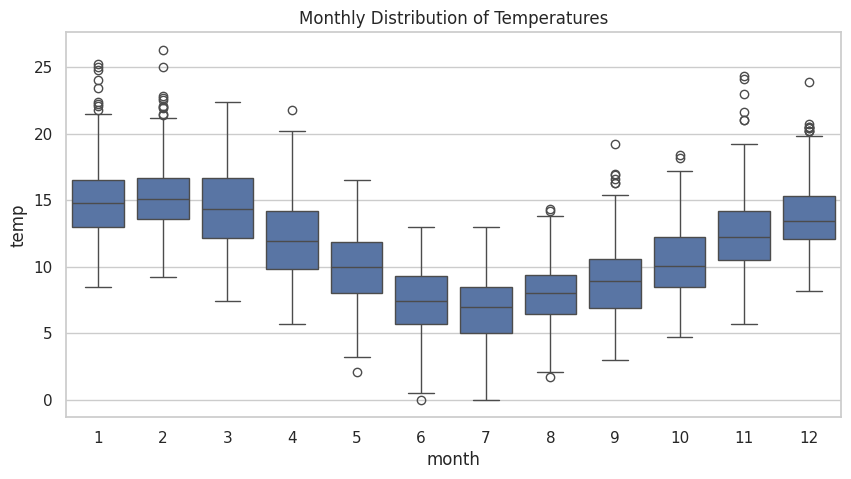

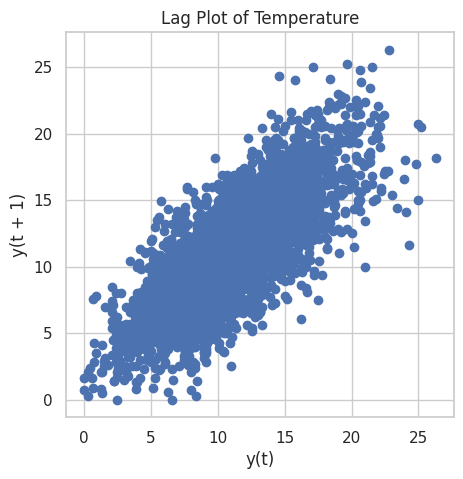

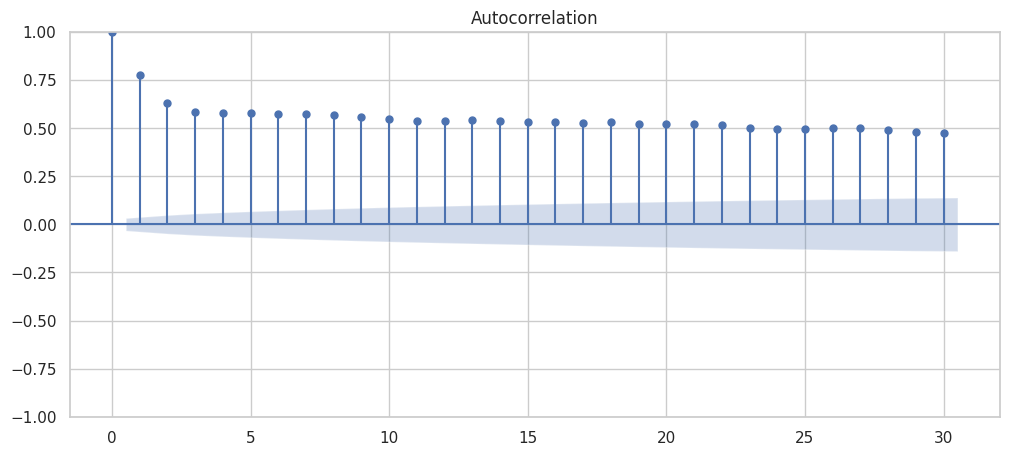

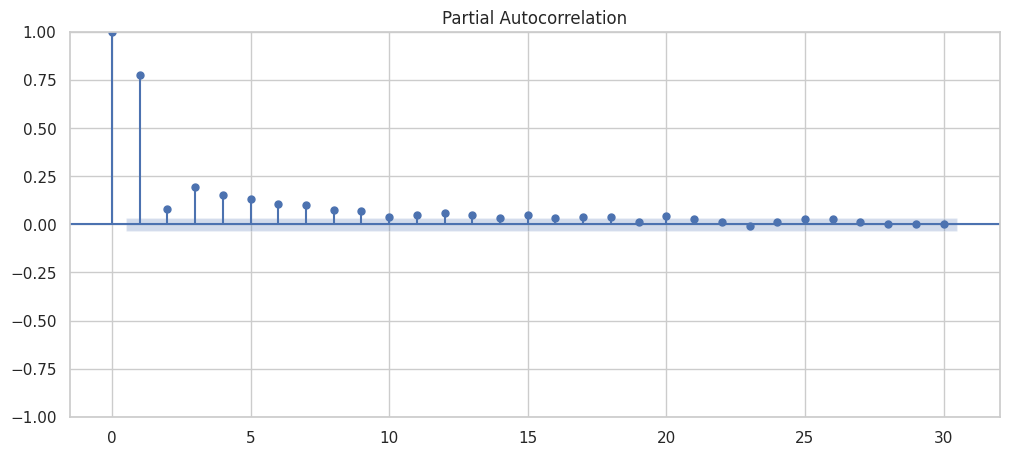

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Histogram + KDE
plt.figure(figsize=(8,4))
sns.histplot(df[target_col], kde=True, bins=30)
plt.title("Distribution of Daily Min Temperatures")
plt.show()

# Boxplot by Month
df["month"] = df["datetime"].dt.month
plt.figure(figsize=(10,5))
sns.boxplot(x="month", y=target_col, data=df)
plt.title("Monthly Distribution of Temperatures")
plt.show()

# Lag plot
plt.figure(figsize=(5,5))
lag_plot(df[target_col])
plt.title("Lag Plot of Temperature")
plt.show()

# Autocorrelation plots
plot_acf(df[target_col], lags=30)
plt.show()

plot_pacf(df[target_col], lags=30)
plt.show()


In [8]:
data = df.copy()

# 5.1 Impute missing values for predictors: simple forward fill then interpolation
data = data.set_index('datetime').sort_index()
data = data.ffill().bfill().interpolate()

# 5.2 Outlier handling for target: cap at 1st and 99th percentiles
low, high = data[target_col].quantile([0.01, 0.99])
data[target_col] = data[target_col].clip(lower=low, upper=high)

# 5.3 Time features
data['hour'] = data.index.hour
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month
data['dayofyear'] = data.index.dayofyear
data['is_weekend'] = (data.index.dayofweek >= 5).astype(int)
data['year'] = data.index.year
data['quarter'] = data.index.quarter

# cyclical encoding for hour and month/dayofyear
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
data['dayofyear_sin'] = np.sin(2 * np.pi * data['dayofyear'] / 365.25)
data['dayofyear_cos'] = np.cos(2 * np.pi * data['dayofyear'] / 365.25)

# 5.4 Lag features - choose based on frequency (if hourly or daily)
# Use these lags: 1, 2, 3, 7, 14, 30 (if applicable)
lags = [1,2,3,7,14,30]
for lag in lags:
    data[f'lag_{lag}'] = data[target_col].shift(lag)

# 5.5 Rolling features
window_sizes = [3,7,14,30]
for w in window_sizes:
    data[f'roll_mean_{w}'] = data[target_col].shift(1).rolling(window=w, min_periods=1).mean()
    data[f'roll_std_{w}']  = data[target_col].shift(1).rolling(window=w, min_periods=1).std().fillna(0)

# 5.6 Drop rows with NaN due to lags
data = data.dropna().reset_index()
print("After feature engineering shape:", data.shape)
data.head()


After feature engineering shape: (3617, 30)


,datetime,temp,month,hour,day,dayofweek,dayofyear,is_weekend,year,quarter,...,lag_14,lag_30,roll_mean_3,roll_std_3,roll_mean_7,roll_std_7,roll_mean_14,roll_std_14,roll_mean_30,roll_std_30
0,1981-01-31,15.4,1,0,31,5,31,1,1981,1,...,20.6,20.7,15.933333,1.115049,16.914286,1.620112,17.021429,2.527747,17.540000,2.609611
1,1981-02-01,15.3,2,0,1,6,32,1,1981,1,...,21.4,17.9,15.333333,0.208167,16.828571,1.690872,16.650000,2.336253,17.363333,2.567366
2,1981-02-02,18.8,2,0,2,0,33,0,1981,1,...,17.7,18.8,15.266667,0.152753,16.657143,1.787789,16.214286,1.912653,17.276667,2.592387
3,1981-02-03,21.4,2,0,3,1,34,0,1981,1,...,15.5,14.6,16.500000,1.992486,16.671429,1.807129,16.292857,1.999024,17.276667,2.592387
4,1981-02-04,19.9,2,0,4,2,35,0,1981,1,...,18.2,15.8,18.500000,3.061046,16.957143,2.378275,16.714286,2.400595,17.503333,2.646987


In [9]:
# 70% train, 15% val, 15% test (by time)
n = len(data)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

train = data.iloc[:train_end].copy()
val   = data.iloc[train_end:val_end].copy()
test  = data.iloc[val_end:].copy()

print("Sizes -> train:", len(train), "val:", len(val), "test:", len(test))

FEATURES = [c for c in data.columns if c not in ['datetime', target_col]]
print("Number of features:", len(FEATURES))
FEATURES[:30]


Sizes -> train: 2531 val: 543 test: 543
Number of features: 28


['month',
 'hour',
 'day',
 'dayofweek',
 'dayofyear',
 'is_weekend',
 'year',
 'quarter',
 'hour_sin',
 'hour_cos',
 'month_sin',
 'month_cos',
 'dayofyear_sin',
 'dayofyear_cos',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_7',
 'lag_14',
 'lag_30',
 'roll_mean_3',
 'roll_std_3',
 'roll_mean_7',
 'roll_std_7',
 'roll_mean_14',
 'roll_std_14',
 'roll_mean_30',
 'roll_std_30']

In [10]:
def evaluate_model(y_true, y_pred, label="model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} -> MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
    return {'mse':mse,'mae':mae,'r2':r2}

# Baseline: naive last observed value (persistence)
y_val = val[target_col].values
y_pred_persist = val['lag_1'].values  # lag_1 is previous timestep's value
evaluate_model(y_val, y_pred_persist, "Persistence baseline")


Persistence baseline -> MSE: 6.5839, MAE: 1.9622, R2: 0.5808


{'mse': 6.5838858195211785,
 'mae': 1.9622467771639043,
 'r2': 0.5808288030504962}

In [11]:
X_train = train[FEATURES].copy()
y_train = train[target_col].copy()
X_val = val[FEATURES].copy()
y_val = val[target_col].copy()
X_test = test[FEATURES].copy()
y_test = test[target_col].copy()

# Track which features are numeric (all are numeric now)
numeric_features = X_train.columns.tolist()

# For linear model pipeline we scale; for tree models it's optional
from sklearn.pipeline import make_pipeline


In [12]:
from sklearn.linear_model import RidgeCV

# Ridge with built-in CV (not time aware) but we'll do manual tune via TimeSeriesSplit
alphas = [0.1, 1, 10, 50, 100]
ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# TimeSeriesSplit for time-aware cross-validation
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'ridge__alpha': alphas}
gs = GridSearchCV(ridge, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
gs.fit(X_train, y_train)
print("Best Ridge params:", gs.best_params_)
y_val_pred = gs.predict(X_val)
evaluate_model(y_val, y_val_pred, "Ridge (tuned)")


Best Ridge params: {'ridge__alpha': 10}
Ridge (tuned) -> MSE: 5.1483, MAE: 1.8337, R2: 0.6722


{'mse': 5.1482881160949825, 'mae': 1.833687994231172, 'r2': 0.6722278983839693}

In [13]:
# Utility to run RandomizedSearchCV for time-series
def tune_model(estimator, param_dist, X, y, n_iter=40, cv=tscv, scoring='r2'):
    rs = RandomizedSearchCV(estimator=estimator, param_distributions=param_dist,
                            n_iter=n_iter, cv=cv, scoring=scoring, n_jobs=-1, random_state=42)
    rs.fit(X, y)
    print("Best params:", rs.best_params_, "Best score:", rs.best_score_)
    return rs

# RandomForest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_param = {
    'n_estimators':[100,200,400],
    'max_depth':[6,10,15,25, None],
    'min_samples_leaf':[1,2,4,8]
}
rf_rs = tune_model(rf, rf_param, X_train, y_train, n_iter=20)
y_val_rf = rf_rs.predict(X_val)
evaluate_model(y_val, y_val_rf, "RandomForest (tuned)")

# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=0)
xgb_param = {
    'n_estimators':[100,300,600],
    'max_depth':[3,5,8,12],
    'learning_rate':[0.01,0.05,0.1],
    'subsample':[0.6,0.8,1],
    'colsample_bytree':[0.6,0.8,1]
}
xgb_rs = tune_model(xgb_model, xgb_param, X_train, y_train, n_iter=25)
y_val_xgb = xgb_rs.predict(X_val)
evaluate_model(y_val, y_val_xgb, "XGBoost (tuned)")

# LightGBM
lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
lgb_param = {
    'n_estimators':[100,300,600],
    'max_depth':[ -1, 6, 10, 15],
    'learning_rate':[0.01,0.05,0.1],
    'num_leaves':[31,50,100],
    'subsample':[0.6,0.8,1]
}
lgb_rs = tune_model(lgb_model, lgb_param, X_train, y_train, n_iter=25)
y_val_lgb = lgb_rs.predict(X_val)
evaluate_model(y_val, y_val_lgb, "LightGBM (tuned)")


Best params: {'n_estimators': 400, 'min_samples_leaf': 4, 'max_depth': 6} Best score: 0.5962152832020445
RandomForest (tuned) -> MSE: 5.1259, MAE: 1.8161, R2: 0.6737
Best params: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8} Best score: 0.6048412361756446
XGBoost (tuned) -> MSE: 5.0034, MAE: 1.7996, R2: 0.6815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3921
[LightGBM] [Info] Number of data points in the train set: 2531, number of used features: 25
[LightGBM] [Info] Start training from score 10.928842
Best params: {'subsample': 0.6, 'num_leaves': 31, 'n_estimators': 300, 'max_depth': -1, 'learning_rate': 0.01} Best score: 0.5785404542219764
LightGBM (tuned) -> MSE: 5.1716, MAE: 1.8281, R2: 0.6707


{'mse': 5.171615303584818, 'mae': 1.8280837411703752, 'r2': 0.6707427442713952}

In [14]:
# Average ensemble of best RF, XGB, LGB on validation
val_preds = (y_val_rf + y_val_xgb + y_val_lgb) / 3
ensemble_metrics = evaluate_model(y_val, val_preds, "Ensemble (avg of RF/XGB/LGB)")


Ensemble (avg of RF/XGB/LGB) -> MSE: 5.0581, MAE: 1.8066, R2: 0.6780


In [15]:
# Combine train + val to refit final models
X_train_all = pd.concat([X_train, X_val], axis=0)
y_train_all = pd.concat([y_train, y_val], axis=0)

# Refit best estimators
best_rf = rf_rs.best_estimator_.fit(X_train_all, y_train_all)
best_xgb = xgb_rs.best_estimator_.fit(X_train_all, y_train_all)
best_lgb = lgb_rs.best_estimator_.fit(X_train_all, y_train_all)

# Predictions on test
pred_rf = best_rf.predict(X_test)
pred_xgb = best_xgb.predict(X_test)
pred_lgb = best_lgb.predict(X_test)
pred_ensemble = (pred_rf + pred_xgb + pred_lgb)/3

# Evaluate
res_rf = evaluate_model(y_test, pred_rf, "RF test")
res_xgb = evaluate_model(y_test, pred_xgb, "XGB test")
res_lgb = evaluate_model(y_test, pred_lgb, "LGB test")
res_ensemble = evaluate_model(y_test, pred_ensemble, "Ensemble test")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3969
[LightGBM] [Info] Number of data points in the train set: 3074, number of used features: 25
[LightGBM] [Info] Start training from score 11.144112
RF test -> MSE: 4.6951, MAE: 1.6914, R2: 0.6889
XGB test -> MSE: 4.6575, MAE: 1.6794, R2: 0.6914
LGB test -> MSE: 4.7538, MAE: 1.7052, R2: 0.6850
Ensemble test -> MSE: 4.6521, MAE: 1.6834, R2: 0.6918


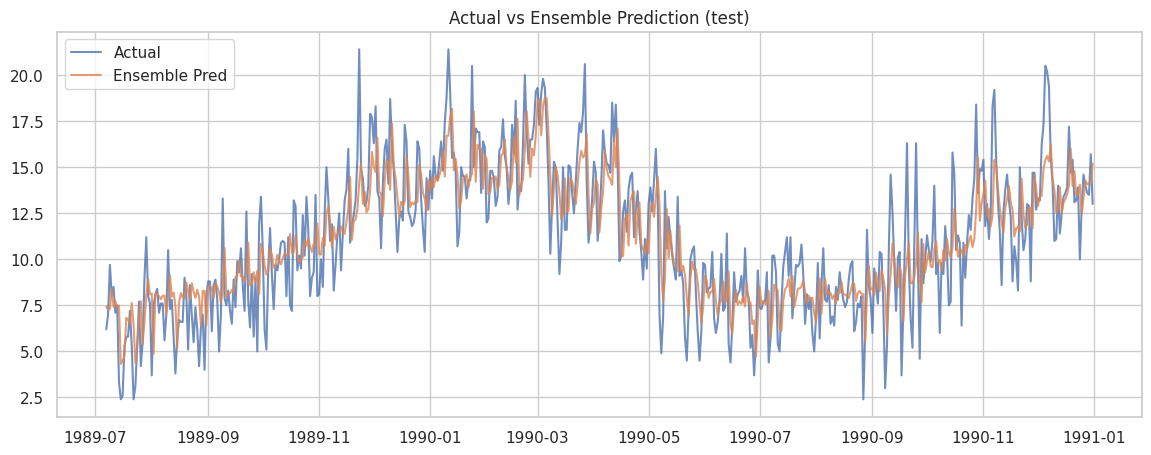

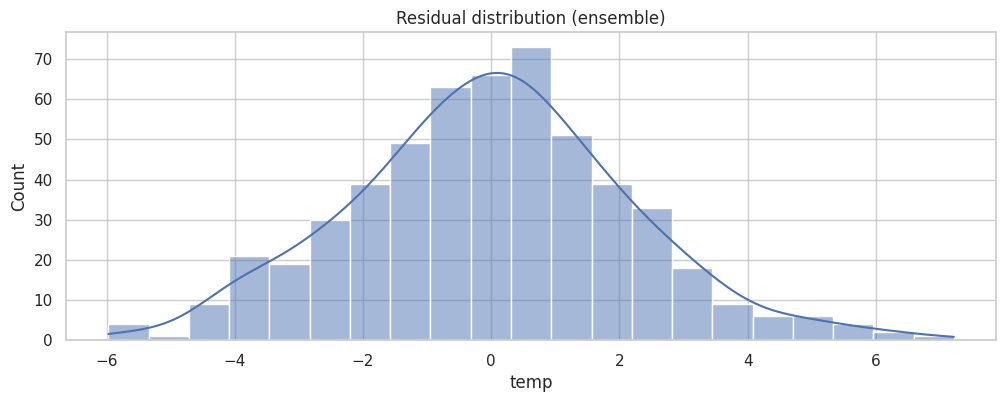

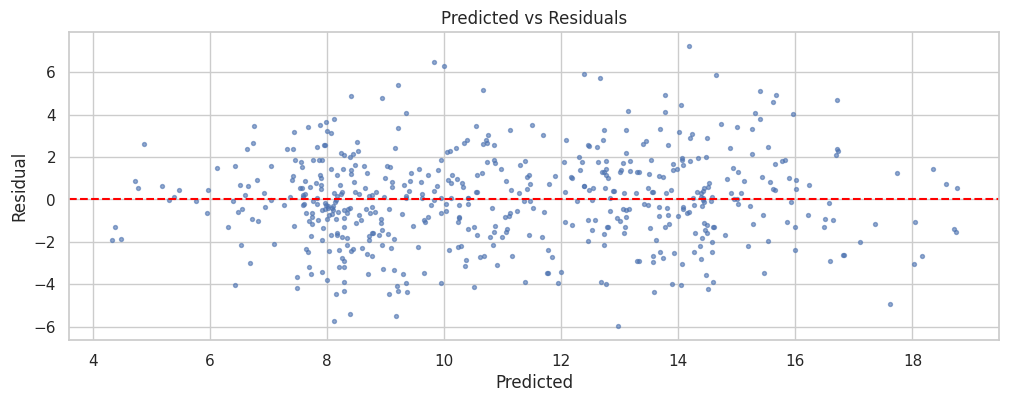

In [16]:
plt.figure(figsize=(14,5))
plt.plot(test['datetime'], y_test, label='Actual', alpha=0.8)
plt.plot(test['datetime'], pred_ensemble, label='Ensemble Pred', alpha=0.8)
plt.legend(); plt.title("Actual vs Ensemble Prediction (test)")
plt.show()

# Residuals plot
residuals = y_test - pred_ensemble
plt.figure(figsize=(12,4))
sns.histplot(residuals, kde=True)
plt.title("Residual distribution (ensemble)")
plt.show()

plt.figure(figsize=(12,4))
plt.scatter(pred_ensemble, residuals, s=8, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted"); plt.ylabel("Residual")
plt.title("Predicted vs Residuals")
plt.show()


In [17]:
# Model feature importance (LightGBM)
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance_lgb': best_lgb.feature_importances_
}).sort_values(by='importance_lgb', ascending=False)
fi.head(20)

# Permutation importance on test for the ensemble's best model (use LGB)
perm = permutation_importance(best_lgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({'feature': X_test.columns, 'perm_importance': perm.importances_mean})
perm_df.sort_values(by='perm_importance', ascending=False).head(20)


,feature,perm_importance
14,lag_1,0.456930
13,dayofyear_cos,0.073331
26,roll_mean_30,0.055313
4,dayofyear,0.013639
22,roll_mean_7,0.009425
24,roll_mean_14,0.008046
12,dayofyear_sin,0.006768
15,lag_2,0.005023
16,lag_3,0.003534
11,month_cos,0.003430


In [18]:
import joblib
joblib.dump(best_lgb, "best_lgb_model.joblib")
joblib.dump(best_xgb, "best_xgb_model.joblib")
joblib.dump(best_rf, "best_rf_model.joblib")

# save predictions
out = test[['datetime']].copy()
out['actual'] = y_test.values
out['pred_rf'] = pred_rf
out['pred_xgb'] = pred_xgb
out['pred_lgb'] = pred_lgb
out['pred_ensemble'] = pred_ensemble
out.to_csv("test_predictions.csv", index=False)
print("Saved models and predictions.")


Saved models and predictions.


Ridge test -> MSE: 4.7760, MAE: 1.7125, R2: 0.6836

--- Ridge Classification Report ---
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       285
           1       0.86      0.84      0.85       258

    accuracy                           0.86       543
   macro avg       0.86      0.86      0.86       543
weighted avg       0.86      0.86      0.86       543



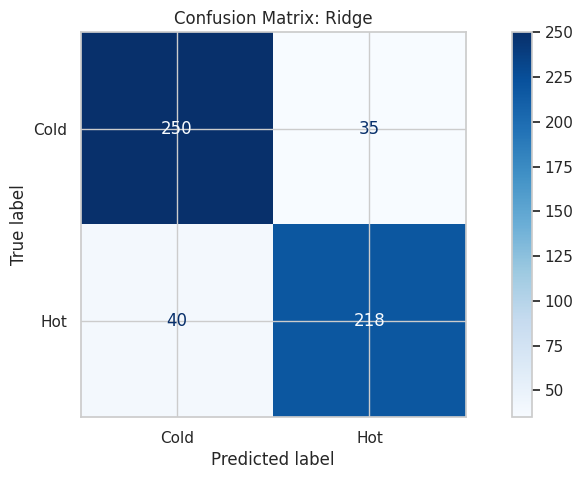


--- RandomForest Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       285
           1       0.88      0.85      0.86       258

    accuracy                           0.87       543
   macro avg       0.87      0.87      0.87       543
weighted avg       0.87      0.87      0.87       543



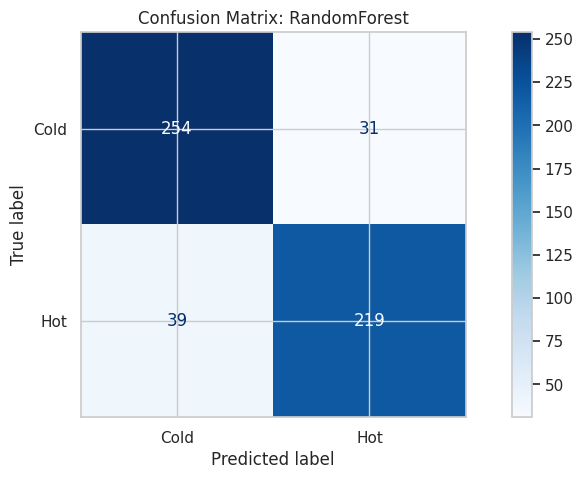


--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       285
           1       0.86      0.86      0.86       258

    accuracy                           0.87       543
   macro avg       0.87      0.87      0.87       543
weighted avg       0.87      0.87      0.87       543



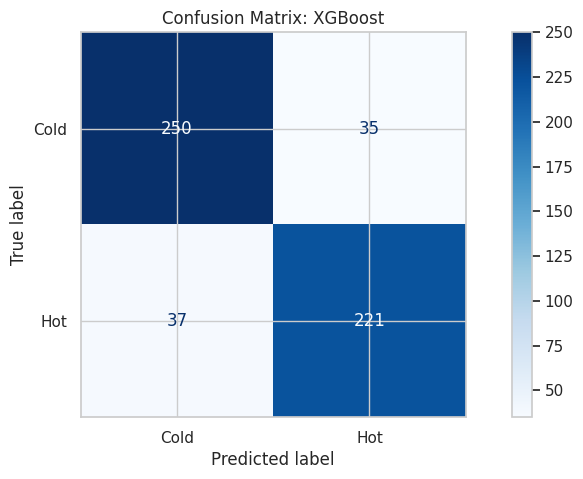


--- LightGBM Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       285
           1       0.87      0.86      0.86       258

    accuracy                           0.87       543
   macro avg       0.87      0.87      0.87       543
weighted avg       0.87      0.87      0.87       543



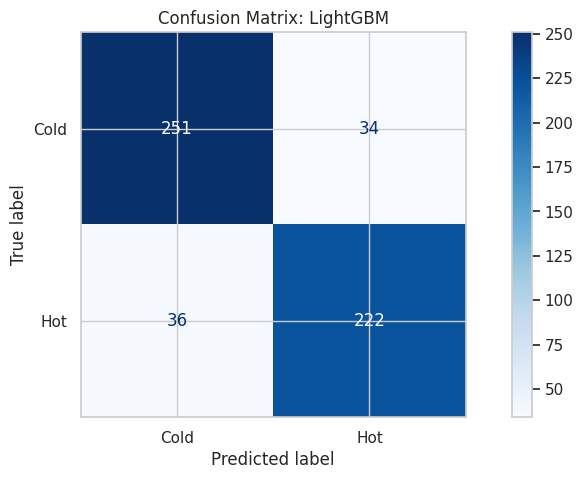


--- Ensemble Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       285
           1       0.87      0.85      0.86       258

    accuracy                           0.87       543
   macro avg       0.87      0.87      0.87       543
weighted avg       0.87      0.87      0.87       543



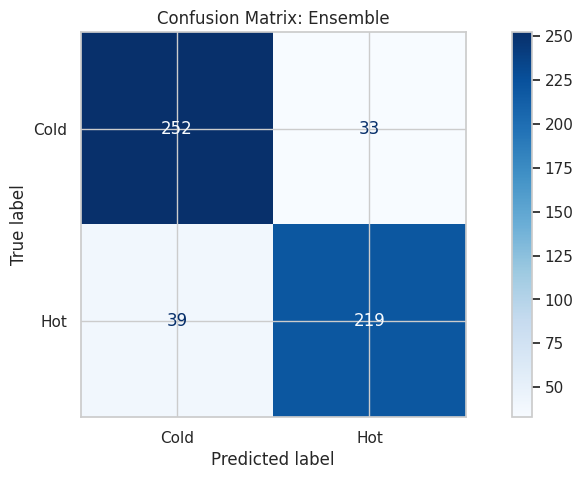

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Collect results dictionary for ALL models
all_results = {}

# Evaluate Ridge (from earlier gs best estimator)
y_pred_ridge = gs.best_estimator_.predict(X_test)
all_results["Ridge"] = evaluate_model(y_test, y_pred_ridge, "Ridge test")

# Already done for RF, XGB, LGB, Ensemble
all_results["RandomForest"] = res_rf
all_results["XGBoost"] = res_xgb
all_results["LightGBM"] = res_lgb
all_results["Ensemble"] = res_ensemble

# Convert regression to classification task (Hot vs Cold day)
threshold = y_test.mean()

# Function to generate classification evaluation for each model
def classification_eval(y_true, y_pred, model_name, threshold):
    y_true_class = (y_true > threshold).astype(int)
    y_pred_class = (y_pred > threshold).astype(int)
    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(y_true_class, y_pred_class))

    cm = confusion_matrix(y_true_class, y_pred_class)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cold","Hot"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

# Run classification-style metrics for each model
classification_eval(y_test, y_pred_ridge, "Ridge", threshold)
classification_eval(y_test, pred_rf, "RandomForest", threshold)
classification_eval(y_test, pred_xgb, "XGBoost", threshold)
classification_eval(y_test, pred_lgb, "LightGBM", threshold)
classification_eval(y_test, pred_ensemble, "Ensemble", threshold)


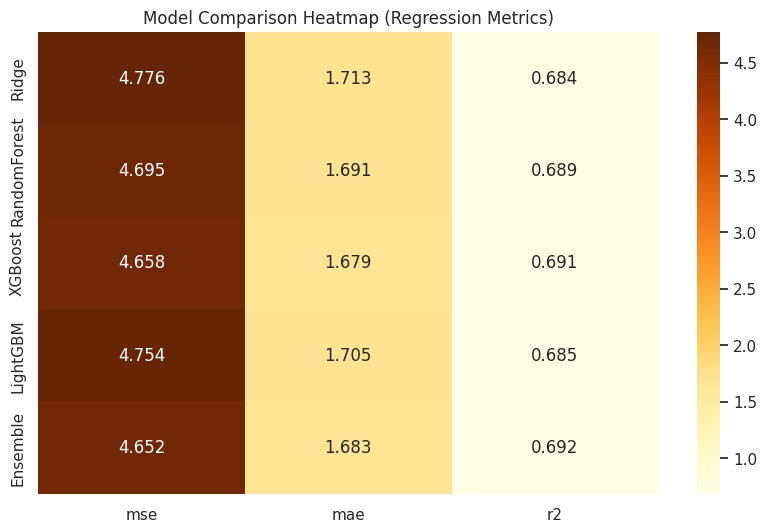

In [20]:
# Convert all regression metrics into a dataframe
results_df = pd.DataFrame(all_results).T
results_df = results_df[["mse","mae","r2"]]

plt.figure(figsize=(10,6))
sns.heatmap(results_df, annot=True, fmt=".3f", cmap="YlOrBr")
plt.title("Model Comparison Heatmap (Regression Metrics)")
plt.show()
